# Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

# Parameters

## System parameters

In [ ]:
L = 25*np.pi                         # box size
c=1                                  # wave speed
Y=10                                 # Young modulus
zeta=0.1                             # coupling constant
k=zeta/Y                             # reduced coupling constant
mu=1                                 # RTP mobility
alpha=1                              # tumbling rate
v0=20                                # RTP speed 
print(np.pi*v0/L)                    # critical tumbling rate
g=1                                  # force amplitude
G1f=g/2                              # Fourier coefficient G1
kappa=0.1                            # spring constant wave
M=np.sqrt(kappa/Y)                   # mass of the wave
w1=np.sqrt(4*np.pi**2/L**2+M**2)     # frequency
N_colloids =  20                     # number of particles

## Simulation parameters

In [ ]:
dt=5*10**(-3)                               # small timestep
N_steps = 1600000                            # number of time steps to integrate
times=np.arange(0, N_steps+1) * dt          # time vector
print(max(times))                           # final time

## Reduced dynamics parameters

In [ ]:
nu1=k**2*N_colloids*Y*mu*abs(G1f)**2/v0**2*(L**2*alpha**2/(np.pi**2*v0**2)-1)      # friction coefficient
print(1/(nu1*L*c**2))                                                              # friction timescale
Gamma1=k*np.sqrt(N_colloids*L*alpha)*abs(G1f)/(np.pi*v0)                           # Gamma1
print(Gamma1*L*c**2)                                                               # noise amplitude
Meff=M*np.sqrt(1-zeta**2*N_colloids*L*2*alpha*mu/v0**2*1/kappa*abs(G1f)**2)        # effective mass
print(Meff/M)
W1=np.sqrt(4*np.pi**2/L**2+Meff**2)                                                # effective mass frequency
omega=c*W1                                                                         # other wave frequency
Omega=np.sqrt(np.complex128(omega**2-nu1**2*L**2/4*c**4))                          # reduced wave frequency
print(Gamma1**2*c**2/(2*nu1*omega**2))

# Functions

In [ ]:
def modz(x): # move to the (-L/2,L/2], due to periodic boundary conditions
    result = np.mod(x, L)
    return np.where(result > L/2, result - L, result)
    
def forcez(z,φ): # force on the RTP particles
    return 2*np.pi*zeta*g*(φ*np.exp(1j*2*np.pi/L*z)).imag

def forceφ(z,φ):  # force on the field
    return -w1**2*c**2*φ-k*G1f*c**2*np.sum(np.exp(-2*np.pi*1j/L*z)) 

def dynamics(N, z0,s0,φ0,ψ0):
    '''
    simulate the system for N steps
    record the time when the probe velocity changes sign
    record the trajectory of the probe velocity
    '''
    
    tumble_times = np.random.exponential(scale=1/alpha,size=N_colloids)  # generate the tumble times for each particle from exponential distribution

    transition_time=[]                                                   # time when transitions between two fixed points happen, to be added
    
    times = np.arange(0, N+1) * dt                                       # time vector
    φs = np.zeros(len(times),dtype=complex)                              # phi_1(t)
    ψs = np.zeros(len(times), dtype=complex)                             # psi_1(t) = d phi_1/dt(t)
    z = np.zeros((len(times),) + z0.shape)                               # z(t) for all RTP particles
    s = np.zeros((len(times),) + s0.shape)                               # spin(t) for all RTp particles

    # initial conditions
    φs[0] = φ0
    ψs[0] = ψ0
    z[0] = z0
    s[0] = s0
    
    for i in range(N):
        if_tumbles = tumble_times < dt         # check if the particles tumble

        # First time step
        Delta_z =(forcez(z[i], φs[i]) + v0*s[i])*dt+if_tumbles*(-2*dt+2*tumble_times)*s[i]*v0
        dφ = ψs[i]*dt
        dψ = forceφ(z[i], φs[i])*dt
        s[i+1] = s[i]
        s[i+1,if_tumbles] = -s[i,if_tumbles]

        tumble_times=tumble_times-dt     #for no flip particles, tumble times decrease by dt, for particles with flip, new tumble_times is negative
        tumble_times[if_tumbles]=np.random.exponential(scale=1/alpha,size=np.sum(if_tumbles))+tumble_times[if_tumbles] #for flipped particles, generate new tumble times

        # second-order Ruge-Kutta method
        Delta_z2 =  Delta_z+(forcez(z[i]+Delta_z,φs[i]+dφ)-forcez(z[i], φs[i]))*dt
        dφ2 = (ψs[i]+dψ)*dt
        dψ2 = forceφ(z[i]+Delta_z,φs[i]+dφ)*dt
        z[i+1] = modz(z[i]+(Delta_z+Delta_z2)/2)
        φs[i+1] = φs[i] +(dφ+dφ2)/2
        ψs[i+1] = ψs[i] +(dψ+dψ2)/2

    return z, φs, ψs, s

# Individual simulation

In [ ]:
# Initial conditions
s0 = np.random.choice([-1,+1],N_colloids)
z0 = np.random.random(N_colloids)*L-L/2
φ0 = 1
ψ0 = 2

# Expected value in reduced dynamics
avφ=np.exp(-nu1*L/2*c**2*times)*(φ0*np.cos(Omega*times)+(nu1*L*c**2*φ0+2*ψ0)/(2*Omega)*np.sin(Omega*times))
varφ = Gamma1**2*c**2/(2*Omega**2*nu1*omega**2)*(Omega**2-omega**2* np.exp(-nu1*L*c**2*times)+ nu1*c**2*L/2*np.exp(-nu1*L*c**2*times)*(nu1*c**2*L/2*np.cos(2*Omega*times)-Omega*np.sin(2*Omega*times)))

z, φs, ψs, sigmas= dynamics(N_steps, z0,s0, φ0, ψ0)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times, φs.real, label='Simulation')
plt.plot(times, avφ.real, label='Eq. (57)')
ax.set_ylabel(r"$\Re(\phi_1(t))$", fontsize = 15, rotation = 0,labelpad=30)
ax.set_xlabel(r"$t$", fontsize = 15)
plt.title("Mode vs time")
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times, φs.imag, label='Simulation')
plt.plot(times, avφ.imag, label='Eq. (57)')
ax.set_ylabel(r"$\Im(\phi_1(t))$", fontsize = 15, rotation = 0,labelpad=30)
ax.set_xlabel(r"$t$", fontsize = 15)
plt.title("Mode vs time")
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
avψ=np.gradient(avφ, times)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times, ψs.real, label='Simulation')
plt.plot(times, avψ.real, label='Derivative of Eq. (7)')
ax.set_ylabel(r"$\Re(\psi_1(t))$", fontsize = 15, rotation = 0,labelpad=30)
ax.set_xlabel(r"$t$", fontsize = 15)
plt.title("Mode speed vs time")
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times, ψs.imag, label='Simulation')
plt.plot(times, avψ.imag, label='Derivative of Eq. (7)')
ax.set_ylabel(r"$\Im(\psi_1(t))$", fontsize = 15, rotation = 0,labelpad=30)
ax.set_xlabel(r"$t$", fontsize = 15)
plt.title("Mode speed vs time")
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times, z[:,0], label = 'Particle 1')
ax.set_ylabel(r"$z(t)$", fontsize = 15, rotation = 0,labelpad=15)
ax.set_xlabel(r"$t$", fontsize = 15)
plt.title("RTP trajectory: position vs time")
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times, sigmas[:,0], label = 'Spin 1')
ax.set_ylabel(r"$s(t)$", fontsize = 15, rotation = 0,labelpad=15)
ax.set_xlabel(r"$t$", fontsize = 15)
plt.title("RTP trajectory: spin vs time")
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

# Simulations over many realisations

In [ ]:
# Initial conditions
z0 = np.random.random(N_colloids)*L-L/2
s0 = np.random.choice([-1,+1],N_colloids)
φ0 = 1
ψ0 = 2


trials=100 # amount of realisations

# Arrays to store all paths
φ_all = np.zeros((trials, N_steps+1),dtype=complex)
ψ_all = np.zeros((trials, N_steps+1),dtype=complex)
#z_all = np.zeros((trials, N_colloids,N_steps+1))

for i in range(trials):
    φs, ψs =dynamics(N_steps, z0,s0, φ0, ψ0)[1:3]
    
    φ_all[i, :] = φs
    ψ_all[i, :] = ψs
    #for j in range(N_colloids):  #include if you also want the RTP trajectories
     #   z_all[i,j,:] = z[:,j]
    
    print(i)                      # iteration number


φ_mean = np.mean(φ_all, axis=0)
ψ_mean = np.mean(ψ_all, axis=0)
#z_mean = np.mean(z_all, axis=0)

# Standard deviation (for envelope)
φ_std = np.std(φ_all, axis=0)
ψ_std = np.std(ψ_all, axis=0)
#z_std = np.std(z_all, axis=0)

In [ ]:
# Initial conditions
φ0 = 1
ψ0 = 2

# Expected value and variance in reduced dynamics
avφ=np.exp(-nu1*L/2*c**2*times)*(φ0*np.cos(Omega*times)+(nu1*L*c**2*φ0+2*ψ0)/(2*Omega)*np.sin(Omega*times))
varφ = Gamma1**2*c**2/(2*Omega**2*nu1*omega**2)*(Omega**2-omega**2* np.exp(-nu1*L*c**2*times)+ nu1*c**2*L/2*np.exp(-nu1*L*c**2*times)*(nu1*c**2*L/2*np.cos(2*Omega*times)-Omega*np.sin(2*Omega*times)))

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times, varφ.real, label='Eq. (57)')
ax.plot(times,times*0+Gamma1**2*c**2/(2*nu1*c**2*W1**2), label='Eq. (59)', linestyle='--')
ax.set_ylabel(r"$\Re(\langle\phi_1(t) \rangle_s)$", fontsize = 15, rotation = 0,labelpad=30)
ax.set_xlabel(r"$t$", fontsize = 15)
ax.legend(fontsize = 12)
plt.title("Average Mode value vs time")
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

# Real part φ1

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times, avφ.real, label='Eq. (57)')
plt.plot(times, φ_mean.real,label='Simulation')
ax.set_ylabel(r"$\Re(\langle\phi_1(t) \rangle_s)$", fontsize = 15, rotation = 0,labelpad=30)
ax.set_xlabel(r"$t$", fontsize = 15)
ax.legend(fontsize = 12)
plt.title("Average Mode value vs time")
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
tend=3000                                                                                       # plot average up to this time
Nend=int(tend/dt)                                                                               # plot average up to this index
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times[:Nend], avφ.real[:Nend], label='Eq. (57)', color = 'orange')
plt.plot(times[:Nend], φ_mean.real[:Nend],label='Simulation', color = 'deepskyblue')
ax.set_ylabel(r"$\Re(\langle\phi_1(t) \rangle_s)$", fontsize = 15, rotation = 0,labelpad=30)
ax.set_xlabel(r"$t$", fontsize = 15)
ax.legend(fontsize = 12)
plt.title("Average Mode value vs time")
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
tend=3000                                                                                      # plot average up to this time
Nend=int(tend/dt)                                                                              # plot average up to this index
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times[:Nend], avφ.imag[:Nend], label='Eq. (57)', color = 'orange')
plt.plot(times[:Nend], φ_mean.imag[:Nend],label='Simulation', color = 'deepskyblue')
ax.set_ylabel(r"$\Im(\langle\phi_1(t) \rangle_s)$", fontsize = 15, rotation = 0,labelpad=30)
ax.set_xlabel(r"$t$", fontsize = 15)
ax.legend(fontsize = 12)
plt.title("Average Mode value vs time")
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
tend=8000                                                                                                      # plot average up to this time
Nend=int(tend/dt)                                                                                              # plot average up to this index
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(times[:Nend], φ_std[:Nend]**2, label='Simulation', color = 'deepskyblue')
ax.plot(times[:Nend], varφ[:Nend].real, label='Eq. (58)', color = 'orange')
ax.plot(times[:Nend],times[:Nend]*0+Gamma1**2*c**2/(2*nu1*c**2*W1**2), label='Eq. (59)', linestyle='--')
ax.set_xlabel(r"$t$", fontsize = 15)
ax.set_ylabel(r"$\text{Var}(\phi_1(t) )_s$", fontsize = 15, rotation = 0,labelpad=45)
ax.legend(fontsize = 12)
plt.title("Variance in mode values vs time")
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
tend=8000                                                                                                           # plot average up to this time
Nend=int(tend/dt)                                                                                                   # plot average up to this index
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(times[:Nend], φ_std[:Nend], label='Simulation', color = 'deepskyblue')
ax.plot(times[:Nend], np.sqrt(varφ)[:Nend].real, label='Eq. (58)', color = 'orange')
ax.plot(times[:Nend],times[:Nend]*0+np.sqrt(Gamma1**2*c**2/(2*nu1*c**2*W1**2)), label='Eq. (59)', linestyle='--')
ax.set_xlabel(r"$t$", fontsize = 15)
ax.set_ylabel(r"$\Delta(\phi_1(t) )_s$", fontsize = 15, rotation = 0,labelpad=45)
ax.legend(fontsize = 12)
plt.title("Variance in mode values vs time")
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
tend=1000                                                                                                         # plot average up to this time
Nend=int(tend/dt)                                                                                                 # plot average up to this index
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(times[:Nend], φ_std[:Nend]**2, label='Simulation')
ax.plot(times[:Nend], varφ.real[:Nend], label='Eq. (8)')
#ax.plot(times[:Nend], varφ.real[:Nend]*0+Gamma1**2*c**2/(2*nu1*c**2*W1**2), label='Eq. (9)', linestyle='--')
ax.set_xlabel(r"$t$", fontsize = 15)
ax.set_ylabel(r"$\text{Var}(\phi_1(t) )_s$", fontsize = 15, rotation = 0,labelpad=45)
ax.legend(fontsize = 12)
plt.title("Variance in mode values vs time")
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(times, φ_std, label='Simulation')
ax.plot(times, np.sqrt(varφ.real), label='Eq. (58)')
ax.plot(times, times*0+np.sqrt(Gamma1**2*c**2/(2*nu1*c**2*W1**2)), label='Eq. (59)', linestyle='--')
ax.set_xlabel(r"$t$", fontsize = 15)
ax.set_ylabel(r"$\Delta(\phi_1(t) )_s$", fontsize = 15, rotation = 0,labelpad=45)
ax.legend(fontsize = 12)
plt.title("Standard deviation in mode values vs time")
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times, φ_all[2].real,label='Trial 3')
plt.plot(times, φ_all[8].real,label='Trial 8')
#plt.plot(times, avφ.real, label='Eq. (7)')
ax.set_ylabel(r"$\phi_1(t)$", fontsize = 15, rotation = 0,labelpad=30)
ax.set_xlabel(r"$t$", fontsize = 15)
ax.legend(fontsize = 12)
plt.title("Modes vs time")
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
for i in range(trials):
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.plot(times, φ_all[i].real,label= 'Trial %s' % (i+1))
    ax.set_ylabel(r"$\phi_1(t)$", fontsize = 15, rotation = 0,labelpad=30)
    ax.set_xlabel(r"$t$", fontsize = 15)
    ax.legend(fontsize = 12)
    plt.title("Modes vs time")
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    plt.tight_layout()
    plt.show()

# Imaginary part φ1

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times, φ_mean.imag,label='Simulation')
plt.plot(times, avφ.imag, label='Eq. (57)')
ax.set_ylabel(r"$\Im(\langle\phi_1(t) \rangle_s)$", fontsize = 15, rotation = 0,labelpad=40)
ax.set_xlabel(r"$t$", fontsize = 15)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

# Real part ψ1

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times, ψ_mean.real,label='Simulation')
plt.plot(times, avψ.real, label='Derivative of Eq. (57)')
ax.set_ylabel(r"$\langle\psi_1(t) \rangle_s$", fontsize = 15, rotation = 0,labelpad=30)
ax.set_xlabel(r"$t$", fontsize = 15)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times, ψ_std.real**2,label='Simulation')
plt.plot(times, varψ.real, label='Eq. (58)')
ax.set_ylabel(r"$\text{Var}(\psi_1(t) )_s$", fontsize = 15, rotation = 0,labelpad=45)
ax.set_xlabel(r"$t$", fontsize = 15)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(times, ψ_std, label='Simulation')
ax.plot(times, np.sqrt(varψ.real), label='Eq. (58)')
#ax.plot(times, times*0+np.sqrt(Gamma1**2*c**2/(2*nu1*c**2*W1**2)), label='Eq. (9)', linestyle='--')
ax.set_xlabel(r"$t$", fontsize = 15)
ax.set_ylabel(r"$\Delta(\psi_1(t) )_s$", fontsize = 15, rotation = 0,labelpad=45)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
vφ=np.gradient(φ_mean,times)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times, ψ_mean.real,label='Simulation')
plt.plot(times, vφ.real, label='Derivative from Eq. (57)')
ax.set_ylabel(r"$\langle\psi_1(t) \rangle_s$", fontsize = 15, rotation = 0,labelpad=30)
ax.set_xlabel(r"$t$", fontsize = 15)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

# Load data

## 100 trials negative friction

### System parameters

In [27]:
L = 25*np.pi                         # box size
c=1                                  # wave speed
Y=10                                 # Young modulus
zeta=0.1                             # coupling constant
k=zeta/Y                             # reduced coupling constant
mu=1                                 # RTP mobility
alpha=0.1                              # tumbling rate
v0=20                                # RTP speed 
print(np.pi*v0/L)                    # critical tumbling rate
g=1                                  # force amplitude
G1f=g/2                              # Fourier coefficient G1
kappa=0.1                            # spring constant wave
M=np.sqrt(kappa/Y)                   # mass of the wave
w1=np.sqrt(4*np.pi**2/L**2+M**2)     # frequency
N_colloids =  20                     # number of particles

0.7999999999999999


### Simulation parameters

In [28]:
dt=5*10**(-3)                               # small timestep
N_steps = 600000                            # number of time steps to integrate
times=np.arange(0, N_steps+1) * dt          # time vector
print(max(times))                           # final time

3000.0


### Reduced dynamics parameters

In [29]:
nu1=k**2*N_colloids*Y*mu*abs(G1f)**2/v0**2*(L**2*alpha**2/(np.pi**2*v0**2)-1)      # friction coefficient
print(1/(nu1*L*c**2))                                                              # friction timescale
Gamma1=k*np.sqrt(N_colloids*L*alpha)*abs(G1f)/(np.pi*v0)                           # Gamma1
print(Gamma1*L*c**2)                                                               # noise amplitude
Meff=M*np.sqrt(1-zeta**2*N_colloids*L*2*alpha*mu/v0**2*1/kappa*abs(G1f)**2)        # effective mass
print(Meff/M)
W1=np.sqrt(4*np.pi**2/L**2+Meff**2)                                                # effective mass frequency
omega=c*W1                                                                         # other wave frequency
Omega=np.sqrt(np.complex128(omega**2-nu1**2*L**2/4*c**4))                          # reduced wave frequency
print(Gamma1**2*c**2/(2*nu1*omega**2))

-1034.7597569911163
0.07833213358221879
0.990133852524528
-2.4945183253221237


In [30]:
# Save data. Only use this for new data
#np.save("φ1 negative friction 100 trials.npy", φ_all)
#np.save("ψ1 negative friction 100 trials.npy", ψ_all)
#np.save("times negative friction 100 trials.npy", times)

In [31]:
# Load data
φ1n100 = np.load("φ1 negative friction 100 trials.npy")
ψ1n100 = np.load("ψ1 negative friction 100 trials.npy")
timesn100 = np.load("times negative friction 100 trials.npy")

In [32]:
# Initial values
φ0 = 1
ψ0 = 2

# Expected value and variance in the reduced dynamics
avφ=np.exp(-nu1*L/2*c**2*timesn100)*(φ0*np.cos(Omega*timesn100)+(nu1*L*c**2*φ0+2*ψ0)/(2*Omega)*np.sin(Omega*timesn100))
varφ = Gamma1**2*c**2/(2*Omega**2*nu1*omega**2)*(Omega**2-omega**2* np.exp(-nu1*L*c**2*timesn100)+ nu1*c**2*L/2*np.exp(-nu1*L*c**2*timesn100)*(nu1*c**2*L/2*np.cos(2*Omega*timesn100)-Omega*np.sin(2*Omega*timesn100)))

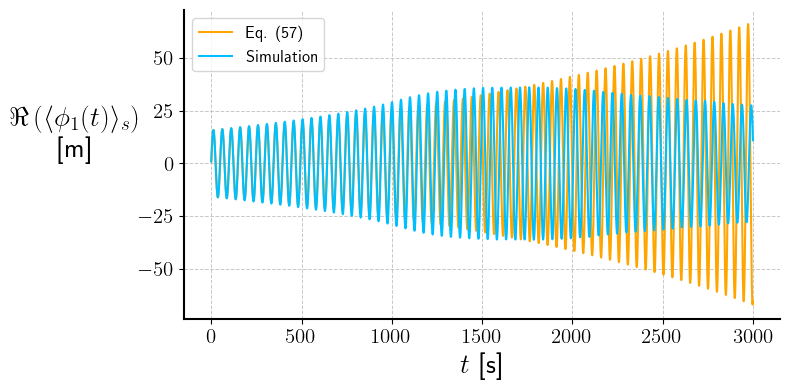

In [34]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times, avφ.real, label='Eq. (57)', color = 'orange')
plt.plot(timesn100, np.mean(φ1n100, axis=0).real,label='Simulation', color = 'deepskyblue')
ax.set_ylabel(r"$\Re\left(\langle\phi_1(t) \rangle_s\right)$"  "\n" "[m]", fontsize = 20, rotation = 0,labelpad=45)
ax.set_xlabel(r"$t$ [s]", fontsize = 20)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)
plt.tight_layout()
plt.show()

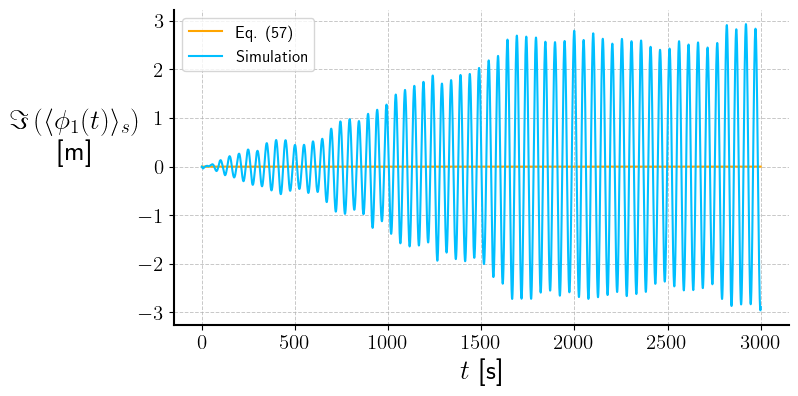

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times, avφ.imag, label='Eq. (57)', color = 'orange')
plt.plot(timesn100, np.mean(φ1n100, axis=0).imag,label='Simulation', color = 'deepskyblue')
ax.set_ylabel(r"$\Im\left(\langle\phi_1(t) \rangle_s\right)$"  "\n" "[m]", fontsize = 20, rotation = 0,labelpad=45)
ax.set_xlabel(r"$t$ [s]", fontsize = 20)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)
plt.show()

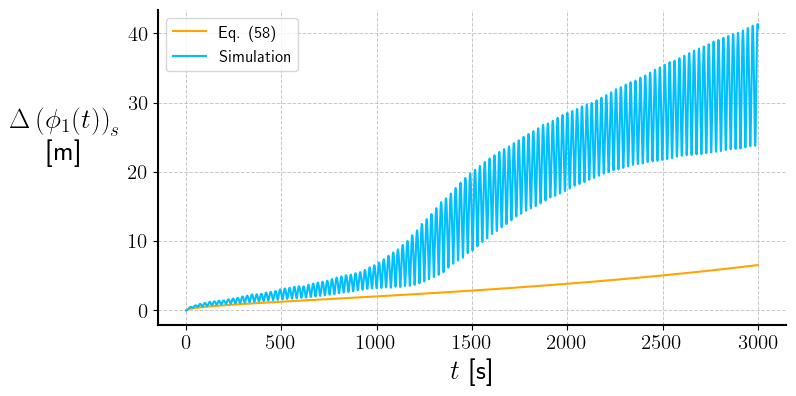

In [39]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(timesn100, np.sqrt(varφ).real, label='Eq. (58)', color = 'orange')
plt.plot(timesn100, np.std(φ1n100, axis=0),label='Simulation', color = 'deepskyblue')
ax.set_ylabel(r"$\Delta\left(\phi_1(t)\right)_s$" "\n" "[m]", fontsize = 20, rotation = 0,labelpad=45)
ax.set_xlabel(r"$t$ [s]", fontsize = 20)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)
plt.show()

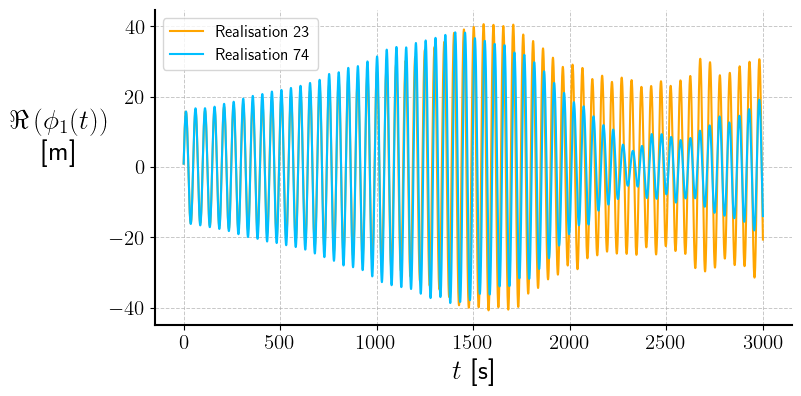

In [40]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(timesn100, φ1n100[23].real, label='Realisation 23', color = 'orange')
plt.plot(timesn100, φ1n100[76].real,label='Realisation 74', color = 'deepskyblue')
ax.set_ylabel(r"$\Re\left(\phi_1(t) \right)$" "\n" "[m]", fontsize = 20, rotation = 0,labelpad=35)
ax.set_xlabel(r"$t$ [s]", fontsize = 20)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)
plt.show()

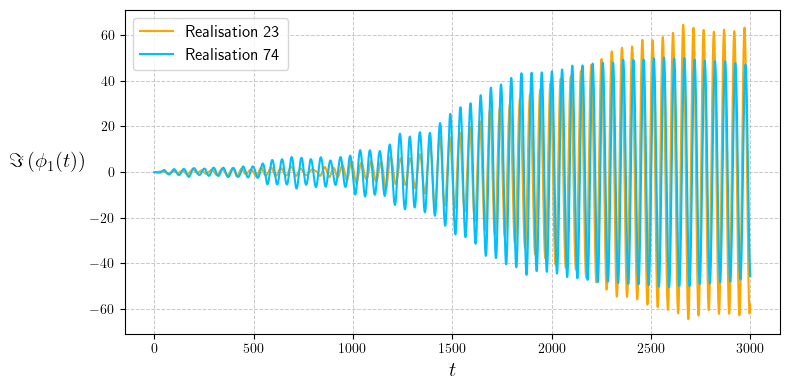

In [41]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(timesn100, φ1n100[23].imag, label='Realisation 23', color = 'orange')
plt.plot(timesn100, φ1n100[76].imag,label='Realisation 74', color = 'deepskyblue')
ax.set_ylabel(r"$\Im\left(\phi_1(t) \right)$", fontsize = 15, rotation = 0,labelpad=30)
ax.set_xlabel(r"$t$", fontsize = 15)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

## Long time simulation negative friction

### System parameters

In [ ]:
L = 25*np.pi                         # box size
c=1                                  # wave speed
Y=10                                 # Young modulus
zeta=0.1                             # coupling constant
k=zeta/Y                             # reduced coupling constant
mu=1                                 # RTP mobility
alpha=0.1                              # tumbling rate
v0=20                                # RTP speed 
print(np.pi*v0/L)                    # critical tumbling rate
g=1                                  # force amplitude
G1f=g/2                              # Fourier coefficient G1
kappa=0.1                            # spring constant wave
M=np.sqrt(kappa/Y)                   # mass of the wave
w1=np.sqrt(4*np.pi**2/L**2+M**2)     # frequency
N_colloids =  20                     # number of particles

### Simulation parameters

In [ ]:
dt=5*10**(-3)                               # small timestep
N_steps = 600000                            # number of time steps to integrate
times=np.arange(0, N_steps+1) * dt          # time vector
print(max(times))                           # final time

### Reduced dynamics parameters

In [ ]:
nu1=k**2*N_colloids*Y*mu*abs(G1f)**2/v0**2*(L**2*alpha**2/(np.pi**2*v0**2)-1)      # friction coefficient
print(1/(nu1*L*c**2))                                                              # friction timescale
Gamma1=k*np.sqrt(N_colloids*L*alpha)*abs(G1f)/(np.pi*v0)                           # Gamma1
print(Gamma1*L*c**2)                                                               # noise amplitude
Meff=M*np.sqrt(1-zeta**2*N_colloids*L*2*alpha*mu/v0**2*1/kappa*abs(G1f)**2)        # effective mass
print(Meff/M)
W1=np.sqrt(4*np.pi**2/L**2+Meff**2)                                                # effective mass frequency
omega=c*W1                                                                         # other wave frequency
Omega=np.sqrt(np.complex128(omega**2-nu1**2*L**2/4*c**4))                          # reduced wave frequency
print(Gamma1**2*c**2/(2*nu1*omega**2))

In [ ]:
# Save simulation data. Only apply if you want to save new data
#np.save("φ1 negative friction 10 trials long time.npy", φ_all)
#np.save("ψ1 negative friction 10 trials long time.npy", ψ_all)
#np.save("times negative friction 10 trials long time.npy", times)

In [ ]:
# Load simulation data
φ1n10L = np.load("φ1 negative friction 10 trials long time.npy")
ψ1n10L = np.load("ψ1 negative friction 10 trials long time.npy")
timesn10L = np.load("times negative friction 10 trials long time.npy")

In [ ]:
# Initial values
φ0 = 1
ψ0 = 2

# Expected value and variance in the reduced dynamics
avφ=np.exp(-nu1*L/2*c**2*timesn10L)*(φ0*np.cos(Omega*timesn10L)+(nu1*L*c**2*φ0+2*ψ0)/(2*Omega)*np.sin(Omega*timesn10L))
varφ = Gamma1**2*c**2/(2*Omega**2*nu1*omega**2)*(Omega**2-omega**2* np.exp(-nu1*L*c**2*timesn10L)+ nu1*c**2*L/2*np.exp(-nu1*L*c**2*timesn10L)*(nu1*c**2*L/2*np.cos(2*Omega*timesn10L)-Omega*np.sin(2*Omega*timesn10L)))

In [ ]:
tend=2000                       # plot the reduced dynamics case up to this time
Nend=int(tend/dt)               # Index of the above time
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(timesn10L, np.mean(φ1n10L, axis=0).real,label='Simulation',color = 'deepskyblue')
plt.plot(times[:Nend], avφ.real[:Nend], label='Eq. (57)', color = 'orange')
ax.set_ylabel(r"$\Re\left(\langle\phi_1(t) \rangle_s\right)$"  "\n" "[m]", fontsize = 20, rotation = 0,labelpad=45)
ax.set_xlabel(r"$t$ [s]", fontsize = 20)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)
plt.show()

In [ ]:
tend=2000                       # plot the reduced dynamics case up to this time
Nend=int(tend/dt)               # Index of the above time
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(timesn10L, np.mean(φ1n10L, axis=0).imag,label='Simulation', color = 'deepskyblue')
plt.plot(timesn10L, avφ.imag, label='Eq. (57)', color = 'orange')
ax.set_ylabel(r"$\Im\left(\langle\phi_1(t) \rangle_s\right)$"  "\n" "[m]", fontsize = 20, rotation = 0,labelpad=45)
ax.set_xlabel(r"$t$ [s]", fontsize = 20)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)
plt.show()

In [ ]:
tend=2000                       # plot the reduced dynamics case up to this time
Nend=int(tend/dt)               # Index of the above time
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(timesn10L, abs(np.mean(φ1n10L, axis=0)),label='Simulation')
plt.plot(times[:Nend], abs(avφ)[:Nend], label='Eq. (57)')
ax.set_ylabel(r"$\Re\left(\langle\phi_1(t) \rangle_s\right)$"  "\n" r"$[m]$", fontsize = 15, rotation = 0,labelpad=35)
ax.set_xlabel(r"$t$ [s]", fontsize = 15)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
tend=7500                       # plot the reduced dynamics case up to this time
Nend=int(tend/dt)               # Index of the above time
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(timesn10L[0:Nend], np.sqrt(varφ)[0:Nend].real, label='Eq. (58)', color = 'orange')
plt.plot(timesn10L, np.std(φ1n10L, axis=0),label='Simulation', color = 'deepskyblue')
ax.set_ylabel(r"$\Delta\left(\phi_1(t)\right)_s$" "\n" "[m]", fontsize = 20, rotation = 0,labelpad=45)
ax.set_xlabel(r"$t$ [s]", fontsize = 20)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(timesn10L, φ1n10L[2].real, label='Realisation 2', color = 'deepskyblue')
#plt.plot(timesn10L, φ1n10L[9].real,label='Realisation 74', color = 'deepskyblue')
ax.set_ylabel(r"$\Re\left(\phi_1(t) \right)$" "\n" "[m]", fontsize = 20, rotation = 0,labelpad=35)
ax.set_xlabel(r"$t$ [s]", fontsize = 20)
#ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)
plt.show()

## 100 trials positive friction case

### System parameters

In [ ]:
L = 25*np.pi                         # box size
c=1                                  # wave speed
Y=10                                 # Young modulus
zeta=0.1                             # coupling constant
k=zeta/Y                             # reduced coupling constant
mu=1                                 # RTP mobility
alpha=1                              # tumbling rate
v0=20                                # RTP speed 
print(np.pi*v0/L)                    # critical tumbling rate
g=1                                  # force amplitude
G1f=g/2                              # Fourier coefficient G1
kappa=0.1                            # spring constant wave
M=np.sqrt(kappa/Y)                   # mass of the wave
w1=np.sqrt(4*np.pi**2/L**2+M**2)     # frequency
N_colloids =  20                     # number of particles

### Simulation parameters

In [ ]:
dt=5*10**(-3)                               # small timestep
N_steps = 600000                            # number of time steps to integrate
times=np.arange(0, N_steps+1) * dt          # time vector
print(max(times))                           # final time

### Reduced dynamics parameters

In [ ]:
nu1=k**2*N_colloids*Y*mu*abs(G1f)**2/v0**2*(L**2*alpha**2/(np.pi**2*v0**2)-1)      # friction coefficient
print(1/(nu1*L*c**2))                                                              # friction timescale
Gamma1=k*np.sqrt(N_colloids*L*alpha)*abs(G1f)/(np.pi*v0)                           # Gamma1
print(Gamma1*L*c**2)                                                               # noise amplitude
Meff=M*np.sqrt(1-zeta**2*N_colloids*L*2*alpha*mu/v0**2*1/kappa*abs(G1f)**2)        # effective mass
print(Meff/M)
W1=np.sqrt(4*np.pi**2/L**2+Meff**2)                                                # effective mass frequency
omega=c*W1                                                                         # other wave frequency
Omega=np.sqrt(np.complex128(omega**2-nu1**2*L**2/4*c**4))                          # reduced wave frequency
print(Gamma1**2*c**2/(2*nu1*omega**2))
avφ=np.exp(-nu1*L/2*c**2*times)*(φ0*np.cos(Omega*times)+(nu1*L*c**2*φ0+2*ψ0)/(2*Omega)*np.sin(Omega*times))
varφ = Gamma1**2*c**2/(2*Omega**2*nu1*omega**2)*(Omega**2-omega**2* np.exp(-nu1*L*c**2*times)+ nu1*c**2*L/2*np.exp(-nu1*L*c**2*times)*(nu1*c**2*L/2*np.cos(2*Omega*times)-Omega*np.sin(2*Omega*times)))

In [ ]:
# Save simulation data. Only apply if you want to save new data
#np.save("φ1 positive friction 100 trials.npy", φ_all)
#np.save("ψ1 positive friction 100 trials.npy", ψ_all)
#np.save("times positive friction 100 trials.npy", times)

In [ ]:
# Load simulation data
φ1p100 = np.load("φ1 positive friction 100 trials.npy")
ψ1p100 = np.load("ψ1 positive friction 100 trials.npy")
timesp100 = np.load("times positive friction 100 trials.npy")

In [ ]:
# Initial values
φ0 = 1
ψ0 = 2

# Expected value and variance in the reduced dynamics
avφ=np.exp(-nu1*L/2*c**2*timesp100)*(φ0*np.cos(Omega*timesp100)+(nu1*L*c**2*φ0+2*ψ0)/(2*Omega)*np.sin(Omega*timesp100))
varφ = Gamma1**2*c**2/(2*Omega**2*nu1*omega**2)*(Omega**2-omega**2* np.exp(-nu1*L*c**2*timesp100)+ nu1*c**2*L/2*np.exp(-nu1*L*c**2*timesp100)*(nu1*c**2*L/2*np.cos(2*Omega*timesp100)-Omega*np.sin(2*Omega*timesp100)))

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(timesp100, avφ.real, label='Eq. (57)', color = 'orange')
plt.plot(timesp100, np.mean(φ1p100, axis=0).real,label='Simulation', color = 'deepskyblue')
ax.set_ylabel(r"$\Re\left(\langle\phi_1(t) \rangle_s\right)$"  "\n" r"$[m]$", fontsize = 15, rotation = 0,labelpad=35)
ax.set_xlabel(r"$t$ [s]", fontsize = 15)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(timesp100, np.mean(φ1p100, axis=0).imag,label='Simulation', color = 'deepskyblue')
plt.plot(timesp100, avφ.imag, label='Eq. (58)', color = 'orange')
ax.set_ylabel(r"$\Im\left(\langle\phi_1(t) \rangle_s\right)$"  "\n" r"$[m]$", fontsize = 15, rotation = 0,labelpad=35)
ax.set_xlabel(r"$t$ [s]", fontsize = 15)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

# 100 trials positive friction intermediate times

In [ ]:
L = 25*np.pi                         # box size
c=1                                  # wave speed
Y=10                                 # Young modulus
zeta=0.1                             # coupling constant
k=zeta/Y                             # reduced coupling constant
mu=1                                 # RTP mobility
alpha=1                              # tumbling rate
v0=20                                # RTP speed 
print(np.pi*v0/L)                    # critical tumbling rate
g=1                                  # force amplitude
G1f=g/2                              # Fourier coefficient G1
kappa=0.1                            # spring constant wave
M=np.sqrt(kappa/Y)                   # mass of the wave
w1=np.sqrt(4*np.pi**2/L**2+M**2)     # frequency
N_colloids =  20                     # number of particles

## Simulation parameters

In [ ]:
dt=5*10**(-3)                               # small timestep
N_steps = 1600000                           # number of time steps to integrate
times=np.arange(0, N_steps+1) * dt          # time vector
print(max(times))                           # final time

## Reduced dynamics parameters

In [ ]:
nu1=k**2*N_colloids*Y*mu*abs(G1f)**2/v0**2*(L**2*alpha**2/(np.pi**2*v0**2)-1)      # friction coefficient
print(1/(nu1*L*c**2))                                                              # friction timescale
Gamma1=k*np.sqrt(N_colloids*L*alpha)*abs(G1f)/(np.pi*v0)                           # Gamma1
print(Gamma1*L*c**2)                                                               # noise amplitude
Meff=M*np.sqrt(1-zeta**2*N_colloids*L*2*alpha*mu/v0**2*1/kappa*abs(G1f)**2)        # effective mass
print(Meff/M)
W1=np.sqrt(4*np.pi**2/L**2+Meff**2)                                                # effective mass frequency
omega=c*W1                                                                         # other wave frequency
Omega=np.sqrt(np.complex128(omega**2-nu1**2*L**2/4*c**4))                          # reduced wave frequency
print(Gamma1**2*c**2/(2*nu1*omega**2))

In [ ]:
#Save simulation data. Only apply if you want to save new data
#np.save("φ1 positive friction 100 trials longer.npy", φ_all)
#np.save("ψ1 positive friction 100 trials longer.npy", ψ_all)
#np.save("times positive friction 100 trials longer.npy", times)

In [ ]:
# Load simulation data
φ1p100L = np.load("φ1 positive friction 100 trials longer.npy")
ψ1p100L = np.load("ψ1 positive friction 100 trials longer.npy")
timesp100L = np.load("times positive friction 100 trials longer.npy")

In [ ]:
# Initial values
φ0 = 1
ψ0 = 2

# Expected value and variance in the reduced dynamics
avφ=np.exp(-nu1*L/2*c**2*timesp100L)*(φ0*np.cos(Omega*timesp100L)+(nu1*L*c**2*φ0+2*ψ0)/(2*Omega)*np.sin(Omega*timesp100L))
varφ = Gamma1**2*c**2/(2*Omega**2*nu1*omega**2)*(Omega**2-omega**2* np.exp(-nu1*L*c**2*timesp100L)+ nu1*c**2*L/2*np.exp(-nu1*L*c**2*timesp100L)*(nu1*c**2*L/2*np.cos(2*Omega*timesp100L)-Omega*np.sin(2*Omega*timesp100L)))

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(timesp100L, avφ.real, label='Eq. (57)', color = 'orange')
plt.plot(timesp100L, np.mean(φ1p100L, axis=0).real,label='Simulation', color = 'deepskyblue')
ax.set_ylabel(r"$\Re\left(\langle\phi_1(t) \rangle_s\right)$"  "\n" r"$[m]$", fontsize = 15, rotation = 0,labelpad=35)
ax.set_xlabel(r"$t$ [s]", fontsize = 15)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
tend=3000                       # plot the reduced dynamics case up to this time
Nend=int(tend/dt)               # Index of the above time
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times[:Nend], avφ.real[:Nend], label='Eq. (57)', color = 'orange')
plt.plot(times[:Nend], np.mean(φ1p100L, axis=0).real[:Nend],label='Simulation', color = 'deepskyblue')
ax.set_ylabel(r"$\Re\left(\langle\phi_1(t) \rangle_s\right)$"  "\n" "[m]", fontsize = 20, rotation = 0,labelpad=45)
ax.set_xlabel(r"$t$ [s]", fontsize = 20)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)
for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(timesp100L, np.mean(φ1p100L, axis=0).imag,label='Simulation', color = 'deepskyblue')
plt.plot(timesp100L, avφ.imag, label='Eq. (58)', color = 'orange')
ax.set_ylabel(r"$\Im\left(\langle\phi_1(t) \rangle_s\right)$"  "\n" r"$[m]$", fontsize = 15, rotation = 0,labelpad=35)
ax.set_xlabel(r"$t$ [s]", fontsize = 15)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
tend=3000                          # plot the reduced dynamics case up to this time
Nend=int(tend/dt)                  # Index of the above time
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(times[:Nend], avφ.imag[:Nend], label='Eq. (57)', color = 'orange')
plt.plot(times[:Nend], np.mean(φ1p100L, axis=0).imag[:Nend],label='Simulation', color = 'deepskyblue')
ax.set_ylabel(r"$\Im\left(\langle\phi_1(t) \rangle_s\right)$"  "\n" "[m]", fontsize = 20, rotation = 0,labelpad=45)
ax.set_xlabel(r"$t$ [s]", fontsize = 20)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)
plt.show()

In [ ]:
tend=8000                     # plot the reduced dynamics case up to this time
Nend=int(tend/dt)             # Index of the above time
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(times[:Nend], np.std(φ1p100L, axis=0)[:Nend], label='Simulation', color = 'deepskyblue')
ax.plot(times[:Nend], np.sqrt(varφ)[:Nend].real, label='Eq. (58)', color = 'orange')
ax.plot(times[:Nend],times[:Nend]*0+np.sqrt(Gamma1**2*c**2/(2*nu1*c**2*W1**2)), label='Eq. (59)', linestyle='--', color = 'lime')
ax.set_ylabel(r"$\Delta\left(\phi_1(t)\right)_s$" "\n" "[m]", fontsize = 20, rotation = 0,labelpad=45)
ax.set_xlabel(r"$t$ [s]", fontsize = 20)
ax.legend(fontsize = 12)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
for axis in 'left', 'bottom':
    ax.spines[axis].set_linewidth(1.5)
plt.show()